In [1]:
%matplotlib inline
import sys
sys.path.append("/home/bianyuan/workspace/Grab_TNGgalaxy/")
# sys.path.append("./Grab_TNGgalaxy")
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import h5py
import seaborn as sns
from tqdm import tqdm
%matplotlib widget
run = 'TNG50'
basePath = '/media/bianyuan/data-TNG-1/' + run + '-1/output'
from astroML.plotting import setup_text_plots
#Lets text in plots use latex
setup_text_plots(usetex=True)

/home/bianyuan/.conda/envs/py310/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
'''Tranfer SnapNum to Redshift'''

import h5py
import scipy
from pynbody import units as units_conv

Redshift_snapshot = np.loadtxt('/home/bianyuan/workspace/data/Redshift_snapshot.txt',comments='Snapshot')

def redshift_snapshot(snapshots, datafile='/home/bianyuan/workspace/data/Redshift_snapshot.txt', return_opt=None):
    snapshots0, redshifts0 = np.loadtxt(datafile, skiprows=1, unpack=True, usecols=[0, 2])
    n_snap = np.size(snapshots)
    if n_snap == 1: 
        redshifts = redshifts0[np.where(snapshots0 == snapshots)][0]
    elif n_snap >1:
        redshifts = np.zeros(n_snap)
        for ii in range(n_snap): 
            if  snapshots[ii] is np.nan: 
                redshifts[ii] = np.nan
            else:
                redshifts[ii] = redshifts0[np.where(snapshots0 == snapshots[ii])][0]
    if return_opt is None: 
        return redshifts
#   elif return_opt == 'age':
#       return age(redshifts)
    elif return_opt == 'FT':
        return FT(redshifts)

def _a_dot(a, h0, om_m, om_l):                                
    om_k = 1.0 - om_m - om_l      
    return h0 * a * np.sqrt(om_m * (a ** -3) + om_k * (a ** -2) + om_l)  

def _a_dot_recip(*args):
    return 1. / _a_dot(*args) 

# The formation time of stars in unit of Gyr
def FT(redshift, h0=0.6774, OmegaM=0.3089, OmegaL=0.6911):
    conv = units_conv.Unit("0.01 s Mpc km^-1").ratio('Gyr')
    redshift = 1./(1. + redshift)
    ns = np.size(redshift)
    if ns > 1:
        FT = np.zeros(ns)
        for ii in range(ns): FT[ii] = scipy.integrate.quad(_a_dot_recip, 0, redshift[ii], (h0, OmegaM, OmegaL))[0] * conv
    else:
        FT = scipy.integrate.quad(_a_dot_recip, 0, redshift, (h0, OmegaM, OmegaL))[0] * conv
    return FT

In [3]:
def mergertree_save(subhalo_id,snap=99):
    h = 0.6774
    fields = ['SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
          'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
          'SubhaloStarMetallicityHalfRad','GroupFirstSub',
          'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
          'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
          'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
    tree = il.sublink.loadTree(basePath,snap,subhalo_id,fields=fields,onlyMPB=True)
    Snap = tree['SnapNum']
    Star_mass = tree['SubhaloMassType'][:,4] * 1e10 / h
    DM_mass = tree['SubhaloMassType'][:,1] * 1e10 / 0.6774 / 1e10
    Gas_mass = tree['SubhaloMassType'][:,0] * 1e10 / 0.6774
    SFR = tree['SubhaloSFR']
    # sSFR = SFR/stellarmass
    sSFR = np.zeros_like(SFR)
    # 添加判断语句
    for j in range(len(Star_mass)):
        if Star_mass[j] == 0:
            sSFR[j] = -1
        else:
            sSFR[j] = (SFR[j]/Star_mass[j]) / 1e-8
    H = tree['SubhaloStarMetalFractions'][:,0]
    Z = np.sum(tree['SubhaloStarMetalFractions'][:, -8:], axis=1)
    ZH = np.zeros_like(Z)
    for j in range(len(Z)):
        ZH[j] = Z[j]/(H[j]+1e-5)
    Re = tree['SubhaloHalfmassRadType'][:,4] * 1000 / h
    galaxydic={}
    galaxydic['Snap']=Snap
    galaxydic['Star_mass']=Star_mass
    galaxydic['DM_mass']=DM_mass
    galaxydic['Gas_mass']=Gas_mass
    galaxydic['sSFR']=sSFR
    galaxydic['Re']=Re
    galaxydic['ZH']=Z/H
    return galaxydic

1.13e+08 8.80e+09
0.05 9.44e-01
1.18e+08 4.68e+09
52


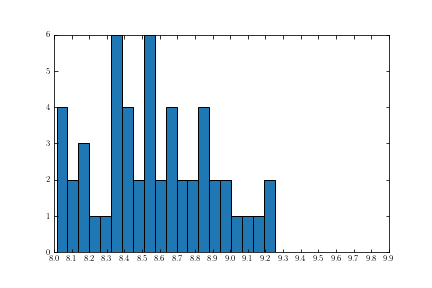

In [89]:
import seaborn as sns
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

MRY_CSSs = np.array(CSSs3['Star mass'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 3.4) & (np.array(CSSs3['[Z/H]_r']) > 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) ) ]
MRI_CSSs = np.array(CSSs3['Star mass'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 3.5) & ((13.8-CSSs3['MWted-Age']) <= 8) & (np.array(CSSs3['[Z/H]_r']) > 0.2) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) ) ]
MRO_CSSs = np.array(CSSs3['Star mass'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 8) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) ) ]
print(f"{min(MRY_CSSs):.2e}", f"{max(MRY_CSSs):.2e}")
print(f"{np.log10(min(MRY_CSSs)/1e8):.2f}", f"{np.log10(max(MRY_CSSs)/1e9):.2e}")

print(np.format_float_scientific(min(MRI_CSSs), precision=2), np.format_float_scientific(max(MRI_CSSs), precision=2))
print(len(MRO_CSSs))
plt.figure()
plt.hist(np.log10(MRO_CSSs),bins=20)
plt.xticks(np.arange(8, 10, 0.1))
plt.savefig('/home/bianyuan/workspace/pic/test.pdf')

In [4]:
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
Normal_Dwarf = sns.load_dataset('Normal_Dwarf',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRY'''
# MRY_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & ((CSSs3['Star mass'] > 1e8)) & (CSSs3['Star mass'] < pow(10,9.75)) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
# MRY_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & ((CSSs3['Star mass'] > 1e8)) & (CSSs3['Star mass'] < pow(10,9.75)) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
# Iso_CSSs_4MRY = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.75))) ) )]
# Iso_ND_4MRY = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9.75))) ) )]

MRY_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRY_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 2.9) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
Iso_CSSs_4MRY = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.65))) ) )]
Iso_ND_4MRY = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9.65))) ) )]

with h5py.File('/home/bianyuan/workspace/data/New_class/MRY/MRY_grp_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRY_grp_CSSs)) as pbar:
        for j in MRY_grp_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MRY/MRY_cl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRY_cl_CSSs)) as pbar:
        for j in MRY_cl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
# with h5py.File('/home/bianyuan/workspace/data/New_class/MRY/Iso_CSSs_4MRY.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_CSSs_4MRY)) as pbar:
#         for j in Iso_CSSs_4MRY:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()
# with h5py.File('/home/bianyuan/workspace/data/New_class/MRY/Iso_ND_4MRY.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_ND_4MRY)) as pbar:
#         for j in Iso_ND_4MRY:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()

  0%|          | 0/127 [00:00<?, ?it/s]

 24%|██▎       | 30/127 [00:02<00:06, 14.97it/s]/tmp/ipykernel_291262/3912773292.py:36: RuntimeWarning: invalid value encountered in divide
  galaxydic['ZH']=Z/H
100%|██████████| 2203/2203 [06:46<00:00,  5.42it/s]


In [34]:
MRY_fl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 0) & ((13.8-CSSs3['MWted-Age']) <= 3.4) & (np.array(CSSs3['[Z/H]_r']) > 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] < 5) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.65))) ) ]
with h5py.File('/home/bianyuan/workspace/data/New_class/MRY/MRY_fl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRY_fl_CSSs)) as pbar:
        for j in MRY_fl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()

100%|██████████| 5/5 [00:00<00:00, 17.99it/s]


In [12]:
'''MRI'''
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)

MRI_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRI_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 2.9) & ((13.8-CSSs3['MWted-Age']) <= 6.4) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
Iso_CSSs_4MRI = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.7))) ) )]
Iso_ND_4MRI = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9.7))) ) )]

with h5py.File('/home/bianyuan/workspace/data/New_class/MRI/MRI_grp_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRI_grp_CSSs)) as pbar:
        for j in MRI_grp_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRI_cl_CSSs)) as pbar:
        for j in MRI_cl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
# with h5py.File('/home/bianyuan/workspace/data/New_class/MRI/Iso_CSSs_4MRI.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_CSSs_4MRI)) as pbar:
#         for j in Iso_CSSs_4MRI:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()
# with h5py.File('/home/bianyuan/workspace/data/New_class/MRI/Iso_ND_4MRI.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_ND_4MRI)) as pbar:
#         for j in Iso_ND_4MRI:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()

  0%|          | 0/19 [00:00<?, ?it/s]

/tmp/ipykernel_291262/581804894.py:36: RuntimeWarning: invalid value encountered in divide
  galaxydic['ZH']=Z/H
100%|██████████| 43/43 [00:00<00:00, 116.01it/s]


In [10]:
import h5py

# 路径到 HDF5 文件
file_path = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'

# 打开 HDF5 文件并读取每个组中的 'Snap' 数据集
snap_data = {}
try:
    with h5py.File(file_path, 'r') as hdf_file:
        # 遍历文件中的每个组
        for group_name in hdf_file.keys():
            # 读取组内的 'Snap' 数据集
            snap_dataset = hdf_file[group_name]['Snap'][()]
            snap_data[group_name] = snap_dataset
except Exception as e:
    error_message = str(e)

# 检查是否有错误信息
if 'error_message' in locals():
    snap_data['Error'] = error_message

snap_data

{'108': array([13.80302507, 13.63131732, 13.31047767]),
 '117308': array([13.80302507, 13.63131732, 13.47653522, 13.31047767, 13.13380461,
        12.97363253, 12.80319692, 12.63589891, 12.45916077, 12.33505065,
        12.09202719, 11.97305562, 11.8557397 , 11.62596476, 11.51345212,
        11.29304641, 11.1851028 , 10.97361142, 10.87001597, 10.66700972,
        10.46943355, 10.27711388, 10.18287272,  9.99812599,  9.81822867,
         9.73005056,  9.5571425 ,  9.38871181,  9.22461868,  9.06472813,
         8.90890983,  8.75703792,  8.60899082,  8.39383592,  8.25484576,
         8.11928651,  7.92215377,  7.79472388,  7.60932795,  7.48942966]),
 '117310': array([13.80302507, 13.63131732, 13.47653522, 13.31047767, 13.13380461,
        12.97363253, 12.80319692, 12.63589891, 12.45916077, 12.33505065,
        12.09202719, 11.97305562, 11.8557397 , 11.62596476, 11.51345212,
        11.29304641, 11.1851028 , 10.97361142, 10.87001597, 10.66700972,
        10.46943355, 10.27711388, 10.18287272,

In [7]:
import h5py

# Open the HDF5 file
file_meta = h5py.File('/home/bianyuan/workspace/data/New_class/MRI/MRI_grp_CSSs_evolution.hdf5', 'r')

# Function to recursively print the data structure
def print_structure(item, indent=""):
    if isinstance(item, h5py.Group):
        print(indent + "Group: " + item.name)
        for key in item.keys():
            print_structure(item[key], indent + "    ")
    elif isinstance(item, h5py.Dataset):
        print(indent + "Dataset: " + item.name)

# Call the function to print the structure
print_structure(file_meta)

# Close the file
file_meta.close()

Group: /
    Group: /368858
        Dataset: /368858/DM_mass
        Dataset: /368858/Gas_mass
        Dataset: /368858/Re
        Dataset: /368858/Snap
        Dataset: /368858/Star_mass
        Dataset: /368858/ZH
        Dataset: /368858/sSFR
    Group: /386288
        Dataset: /386288/DM_mass
        Dataset: /386288/Gas_mass
        Dataset: /386288/Re
        Dataset: /386288/Snap
        Dataset: /386288/Star_mass
        Dataset: /386288/ZH
        Dataset: /386288/sSFR
    Group: /388560
        Dataset: /388560/DM_mass
        Dataset: /388560/Gas_mass
        Dataset: /388560/Re
        Dataset: /388560/Snap
        Dataset: /388560/Star_mass
        Dataset: /388560/ZH
        Dataset: /388560/sSFR
    Group: /388570
        Dataset: /388570/DM_mass
        Dataset: /388570/Gas_mass
        Dataset: /388570/Re
        Dataset: /388570/Snap
        Dataset: /388570/Star_mass
        Dataset: /388570/ZH
        Dataset: /388570/sSFR
    Group: /398791
        Dataset: /398791

In [7]:
import seaborn as sns
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MP'''
MP_fl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & ((CSSs3['Star mass'] > 1e8)) & ((CSSs3['Star mass'] < pow(10,9))) & (CSSs3['Number'] < 5) )]
MP_grp_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & ((CSSs3['Star mass'] > 1e8)) & ((CSSs3['Star mass'] < pow(10,9))) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) )]
MP_cl_CSSs = np.array(CSSs3['ID'])[np.where( (np.array(CSSs3['[Z/H]_r']) <= 0.085) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & ((CSSs3['Star mass'] > 1e8)) & ((CSSs3['Star mass'] < pow(10,9))) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
# Iso_CSSs_4MP = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9))) ) )]
# Iso_ND_4MP = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9))) ) )]

with h5py.File('/home/bianyuan/workspace/data/New_class/MP/MP_fl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MP_fl_CSSs)) as pbar:
        for j in MP_fl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MP/MP_grp_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MP_grp_CSSs)) as pbar:
        for j in MP_grp_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MP/MP_cl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MP_cl_CSSs)) as pbar:
        for j in MP_cl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
# with h5py.File('/home/bianyuan/workspace/data/Iso_CSSs_4MP.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_CSSs_4MP)) as pbar:
#         for j in Iso_CSSs_4MP:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()
# with h5py.File('/home/bianyuan/workspace/data/Iso_ND_4MP.hdf5', 'w') as f:
#     with tqdm(total=len(Iso_ND_4MP)) as pbar:
#         for j in Iso_ND_4MP:
#             grp = f.create_group(str(j))
#             galaxyd = mergertree_save(j)
#             dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
#             dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
#             dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
#             dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
#             dset = grp.create_dataset('Re', data=galaxyd['Re'])
#             dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
#             pbar.update(1)
#     f.close()

  0%|          | 0/73 [00:00<?, ?it/s]/tmp/ipykernel_264775/2514393276.py:34: RuntimeWarning: invalid value encountered in divide
  galaxydic['ZH']=Z/H
100%|██████████| 39/39 [00:00<00:00, 105.89it/s]


In [6]:
import seaborn as sns
CSSs3 = sns.load_dataset('CSSs3',data_home='/home/bianyuan/workspace/data',cache=True)
'''MRO'''
MRO_grp_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (CSSs3['Number'] >= 5) & (np.log10(CSSs3['Groupmass']) <= 13) ) ]
MRO_cl_CSSs = np.array(CSSs3['ID'])[np.where( ((13.8-CSSs3['MWted-Age']) >= 6.4) & ((13.8-CSSs3['MWted-Age']) <= 12.2) & (np.array(CSSs3['[Z/H]_r']) > 0.1) & (CSSs3['Traced or Not'] == 1) & (CSSs3['Number'] > 1) & (CSSs3['Distance_grpvir'] > 0) & (np.log10(CSSs3['Groupmass']) > 13) ) ]
Iso_CSSs_4MRO = np.array(CSSs3['ID'])[np.where( np.array( (CSSs3['Number'] == 1) & (CSSs3['Traced or Not'] == 1) & ((CSSs3['Star mass'] > pow(10,8))) & ((CSSs3['Star mass'] < pow(10,9.3))) ) )]
Iso_ND_4MRO = np.array(Normal_Dwarf['ID'])[np.where( np.array( (Normal_Dwarf['Traced or Not'] == 1) & (Normal_Dwarf['Number'] == 1) & ((Normal_Dwarf['Star mass'] > pow(10,8))) & ((Normal_Dwarf['Star mass'] < pow(10,9.3))) ) )]

with h5py.File('/home/bianyuan/workspace/data/New_class/MRO/MRO_grp_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRO_grp_CSSs)) as pbar:
        for j in MRO_grp_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MRO/MRO_cl_CSSs_evolution.hdf5', 'w') as f:
    with tqdm(total=len(MRO_cl_CSSs)) as pbar:
        for j in MRO_cl_CSSs:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MRO/Iso_CSSs_4MRO.hdf5', 'w') as f:
    with tqdm(total=len(Iso_CSSs_4MRO)) as pbar:
        for j in Iso_CSSs_4MRO:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()
with h5py.File('/home/bianyuan/workspace/data/New_class/MRO/Iso_ND_4MRO.hdf5', 'w') as f:
    with tqdm(total=len(Iso_ND_4MRO)) as pbar:
        for j in Iso_ND_4MRO:
            grp = f.create_group(str(j))
            galaxyd = mergertree_save(j)
            dset = grp.create_dataset('Snap', data=galaxyd['Snap'])
            dset = grp.create_dataset('Star_mass', data=galaxyd['Star_mass'])
            dset = grp.create_dataset('DM_mass', data=galaxyd['DM_mass'])
            dset = grp.create_dataset('Gas_mass', data=galaxyd['Gas_mass'])
            dset = grp.create_dataset('sSFR', data=galaxyd['sSFR'])
            dset = grp.create_dataset('Re', data=galaxyd['Re'])
            dset = grp.create_dataset('ZH', data=galaxyd['ZH'])
            pbar.update(1)
    f.close()

  7%|▋         | 1/15 [00:00<00:02,  5.14it/s]/tmp/ipykernel_291262/3912773292.py:36: RuntimeWarning: invalid value encountered in divide
  galaxydic['ZH']=Z/H
 93%|█████████▎| 14/15 [00:02<00:00,  7.61it/s]

100%|██████████| 2030/2030 [01:26<00:00, 23.57it/s]


In [5]:
import h5py

# Open the HDF5 file
file_meta = h5py.File('/home/bianyuan/workspace/data/MRY_grp_CSSs_evolution.hdf5', 'r')

# Function to recursively print the data structure
def print_structure(item, indent=""):
    if isinstance(item, h5py.Group):
        print(indent + "Group: " + item.name)
        for key in item.keys():
            print_structure(item[key], indent + "    ")
    elif isinstance(item, h5py.Dataset):
        print(indent + "Dataset: " + item.name)

# Call the function to print the structure
print_structure(file_meta)

# Close the file
file_meta.close()

Group: /
    Group: /342453
        Dataset: /342453/DM_mass
        Dataset: /342453/Gas_mass
        Dataset: /342453/Re
        Dataset: /342453/Star_mass
        Dataset: /342453/ZH
        Dataset: /342453/sSFR
    Group: /342465
        Dataset: /342465/DM_mass
        Dataset: /342465/Gas_mass
        Dataset: /342465/Re
        Dataset: /342465/Star_mass
        Dataset: /342465/ZH
        Dataset: /342465/sSFR
    Group: /342466
        Dataset: /342466/DM_mass
        Dataset: /342466/Gas_mass
        Dataset: /342466/Re
        Dataset: /342466/Star_mass
        Dataset: /342466/ZH
        Dataset: /342466/sSFR
    Group: /342475
        Dataset: /342475/DM_mass
        Dataset: /342475/Gas_mass
        Dataset: /342475/Re
        Dataset: /342475/Star_mass
        Dataset: /342475/ZH
        Dataset: /342475/sSFR
    Group: /342476
        Dataset: /342476/DM_mass
        Dataset: /342476/Gas_mass
        Dataset: /342476/Re
        Dataset: /342476/Star_mass
        Datase

In [27]:
import h5py

def collect_group_name(name, obj):
    if isinstance(obj, h5py.Group):
        group_names.append(name)

def traverse_groups(hdf5_file):
    hdf5_file.visititems(collect_group_name)

# 打开 HDF5 文件
file_path = '/home/bianyuan/workspace/data/MRY_grp_CSSs_evolution.hdf5'
with h5py.File(file_path, 'r') as hdf5_file:
    # 初始化一个空列表
    group_names = []
    
    # 遍历组并将组名称添加到列表中
    traverse_groups(hdf5_file)
    
# 打印组名称列表
print(len(group_names))

139


In [20]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def calculate_median(dataset):
    # 将数据集读取到 NumPy 数组中
    data = dataset[:]
    # 按列计算中位数
    median = np.median(data, axis=0)
    # 计算 16% 和 84% 的分位数
    q16 = np.percentile(data, 16, axis=0)
    q84 = np.percentile(data, 84, axis=0)
    return median, q16, q84

# 打开 HDF5 文件
file_path = '/home/bianyuan/workspace/data/MRY_grp_CSSs_evolution.hdf5'
with h5py.File(file_path, 'r') as hdf5_file:
    # 遍历每个组
    for group_name in hdf5_file.keys():
        group = hdf5_file[group_name]
        # 遍历组中的数据集
        for dataset_name in group.keys():
            if dataset_name == 'Re':
                dataset = group[dataset_name]
                # 计算中位数和分位数
                median, q16, q84 = calculate_median(dataset)
                
                # 绘制误差限图
                print(median)
                # plt.plot(np.linspace(99,0,100),median)

                # plt.errorbar(range(int(len(median))), median, yerr=[median - q16, q84 - median], fmt='o', label=dataset_name)

# 设置图例和标签
plt.legend()
plt.xlabel('Column')
plt.ylabel('Median')
plt.title('Median with 16%-84% Error Bars')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


373.26392
539.6603
472.30832
519.04767
569.03577
243.65878
249.91844
322.2595
188.32037
255.18982
234.87297
173.05551
199.47705
382.36307
546.9536
338.6534
1046.4714
246.1247
205.40085
302.06216
226.8664
304.1646
992.3096
432.07758
1007.4953
535.69305
382.04156
468.59903
380.8296
269.07892
339.41266
476.40897
5839.6025
306.68393
450.73608
279.45773
763.47906
278.81424
253.09998
297.5585
218.41278
323.5305
365.96118
519.82367
529.93225
542.1134
203.37979
196.8923
232.60236
217.6753
229.89053
881.1497
843.9168
503.6539
613.37146
470.2812
493.64755
569.611
396.7278
542.9674
261.6755
371.5808
345.6848
265.21918
406.0914
337.23752
438.79047
287.60577
298.8601
349.92
656.47034
437.2986
459.77182
304.4558
329.01437
364.0487
396.86414
487.7008
531.17474
345.97876
597.6075
409.9016
2864.931
316.94287
294.73602
261.2049
309.92233
313.7491
408.1933
273.76657
321.00665
469.70267
276.60565
254.80481
352.89594
283.35052
517.6764
237.11261
378.67548
414.2258
221.95966
329.49722
268.04895
218.08517
29

Text(0.5, 1.0, 'Median with 16%-84% Error Bars')

61


Text(0, 0.5, 'Median of Re')

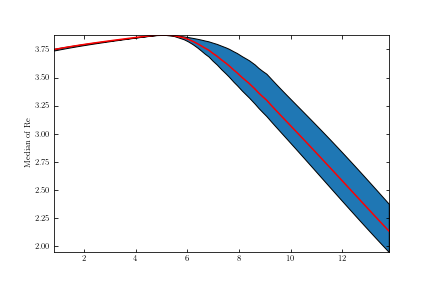

In [92]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib widget

# 打开 HDF5 文件
file_path = '/home/bianyuan/workspace/data/MRY_cl_CSSs_evolution.hdf5'
with h5py.File(file_path, 'r') as hdf5_file:
    # 获取组的数量
    num_groups= len(hdf5_file.keys())
    print(num_groups)
    # 获取最长数据集的长度
    max_length = max(len(group['Re']) for group in hdf5_file.values())
    # 初始化空矩阵
    re_data = np.zeros((len(hdf5_file), max_length))

    # 初始化空列表
    median_values = []
    lower_percentiles = []
    upper_percentiles = []
    
    # 遍历组
    for i, group_name in enumerate(hdf5_file.keys()):
        group = hdf5_file[group_name]
        if isinstance(group, h5py.Group):
            re_dataset = group['Re']
            data_length = len(re_dataset)
            re_data[i, :data_length] = re_dataset[:]
            
re_data[re_data<=0] = np.nan

# 计算每列的中位数
median_values = np.nanmedian(re_data, axis=0)

# 计算每列的误差范围
lower_percentiles = np.nanpercentile(re_data, 16, axis=0)
upper_percentiles = np.nanpercentile(re_data, 84, axis=0)

# 将结果转换为NumPy数组
median_values = np.array(median_values)
lower_percentiles = np.array(lower_percentiles)
upper_percentiles = np.array(upper_percentiles)

# plt.errorbar(x, median_values, yerr=[median_values - lower_percentiles, upper_percentiles - median_values], fmt='o')

# 绘制中位数和误差限图表
lowess_median = sm.nonparametric.lowess(np.log10(median_values), FT(redshift_snapshot(np.linspace(99,2,98))), frac=0.7)
plt.plot(lowess_median[:, 0], lowess_median[:, 1], color='red')
# plt.plot(FT(redshift_snapshot(np.linspace(99,0,100))), np.log10(median_values))
lowess_upper = sm.nonparametric.lowess(np.log10(upper_percentiles), FT(redshift_snapshot(np.linspace(99,2,98))), frac=0.7)
lowess_lower = sm.nonparametric.lowess(np.log10(lower_percentiles), FT(redshift_snapshot(np.linspace(99,2,98))), frac=0.7)
plt.fill_between(lowess_lower[:,0], lowess_lower[:,1], lowess_upper[:,1])

# plt.fill_between(FT(redshift_snapshot(np.linspace(99,0,100))), np.log10(lower_percentiles), np.log10(upper_percentiles))
# plt.errorbar(FT(redshift_snapshot(99-x)), median_values.mean(axis=0), yerr=[median_values.mean(axis=0) - lower_percentiles.mean(axis=0), upper_percentiles.mean(axis=0) - median_values.mean(axis=0)], fmt='o')
# plt.xlabel('Column Index')
plt.ylabel('Median of Re')

In [97]:
def evolution(para):
    # 打开 HDF5 文件
    file_path = '/home/bianyuan/workspace/data/MRY_cl_CSSs_evolution.hdf5'
    with h5py.File(file_path, 'r') as hdf5_file:
        # 获取组的数量
        num_groups= len(hdf5_file.keys())
        print(num_groups)
        # 获取最长数据集的长度
        max_length = max(len(group[str(para)]) for group in hdf5_file.values())
        # 初始化空矩阵
        p_data = np.zeros((len(hdf5_file), max_length))

        # 初始化空列表
        median_values = []
        lower_percentiles = []
        upper_percentiles = []

        # 遍历组
        for i, group_name in enumerate(hdf5_file.keys()):
            group = hdf5_file[group_name]
            if isinstance(group, h5py.Group):
                p_dataset = group[str(para)]
                data_length = len(p_dataset)
                p_data[i, :data_length] = p_dataset[:]
    
    p_data[p_data<=0] = np.nan

    # 计算每列的中位数
    median_values = np.nanmedian(p_data, axis=0)

    # 计算每列的误差范围
    lower_percentiles = np.nanpercentile(p_data, 30, axis=0)
    upper_percentiles = np.nanpercentile(p_data, 70, axis=0)

    # 将结果转换为NumPy数组
    median_values = np.array(median_values)
    lower_percentiles = np.array(lower_percentiles)
    upper_percentiles = np.array(upper_percentiles)

    return median_values, lower_percentiles, upper_percentiles

In [101]:
a,b,c = evolution('Star_mass')
print(c)

61
[3.01218765e+09 2.88451461e+09 3.16595354e+09 3.10742943e+09
 2.87406874e+09 2.72329236e+09 2.52862889e+09 2.55749038e+09
 2.52942152e+09 2.33262054e+09 2.03105766e+09 1.76873792e+09
 1.73172742e+09 1.60823753e+09 1.60066349e+09 1.54528745e+09
 1.48460428e+09 1.44741789e+09 1.31219629e+09 9.62845120e+08
 9.77307776e+08 1.08873086e+09 1.05759695e+09 1.00258605e+09
 1.12747007e+09 1.10472534e+09 1.01328076e+09 8.99551590e+08
 6.99103482e+08 1.00469082e+09 7.33975104e+08 8.23307392e+08
 8.12457792e+08 7.81931584e+08 7.82598720e+08 7.37295872e+08
 7.07599040e+08 6.70191424e+08 6.44833984e+08 6.13766976e+08
 5.75455488e+08 5.19218560e+08 4.69768448e+08 4.30117376e+08
 4.10955648e+08 3.91743808e+08 3.72397248e+08 3.44198400e+08
 2.95381440e+08 2.99529984e+08 2.70017376e+08 2.59494848e+08
 2.52435312e+08 2.37127696e+08 2.22289488e+08 2.08441056e+08
 1.83531312e+08 1.66436944e+08 1.57010160e+08 1.41225744e+08
 1.35574768e+08 1.13117600e+08 1.03378696e+08 9.86459280e+07
 9.33612480e+07 8.865

/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[410037. 409526. 407880. 404542. 402398. 397812. 391567. 388738. 383556.
 380626. 373651. 368501. 367882. 361113. 358567. 352934. 345179. 340824.
 347608. 340863. 336557. 331869. 329146. 325417. 318298. 314404. 310578.
 315800. 313412. 305940. 298755. 295578. 292102.]


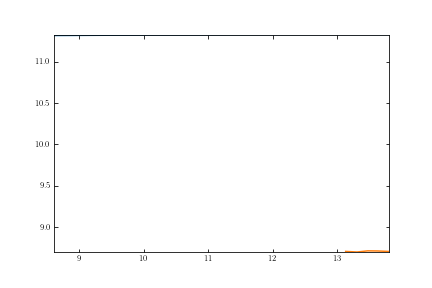

In [81]:
h = 0.6774
snap = 67
subhalo_id = 292102
fields = ['SubhaloMassInHalfRadType','SnapNum','SubhaloStarMetallicity',
          'SubhaloSFRinHalfRad','SubhaloHalfmassRadType',
          'SubhaloStarMetallicityHalfRad','GroupFirstSub',
          'SubhaloMassType','SubhaloSFR','SubhaloHalfmassRadType',
          'SubhaloStarMetallicity','SubhaloWindMass','SubhaloSpin',
          'SubhaloMass','SubhaloIDRaw','SubhaloPos','SubhaloStarMetalFractions']
tree = il.sublink.loadTree(basePath,snap,subhalo_id,fields=fields,onlyMDB=True)
print(tree['SubhaloIDRaw']-tree['SnapNum']*1e12)
Star_mass = tree['SubhaloMassType'][:,4] * 1e10 / h
# print(len(Star_mass))
plt.figure()
plt.plot(FT(redshift_snapshot(tree['SnapNum'])),np.log10(Star_mass))
snap = 99
subhalo_id = 600746
tree = il.sublink.loadTree(basePath,snap,subhalo_id,fields=fields,onlyMPB=True)
Star_mass = tree['SubhaloMassType'][:,4] * 1e10 / h
plt.plot(FT(redshift_snapshot(tree['SnapNum'])),np.log10(Star_mass))
plt.savefig('/home/bianyuan/workspace/pic/connect.pdf')

/tmp/ipykernel_291262/946844046.py:54: RuntimeWarning: divide by zero encountered in log10
  plt.plot(redshifts, np.log10(medians), color=cl, linewidth=3)
/tmp/ipykernel_291262/946844046.py:55: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(redshifts ,np.log10(lower_quartiles) ,np.log10(upper_quartiles) , color=cl, edgecolor='none')


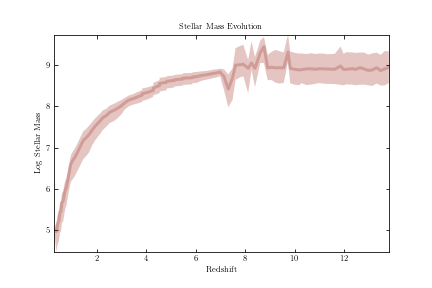

In [41]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 假设 transformations 和 redshift_snapshot 函数已定义
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function
# grp = 'color_for_plot'

path1 = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'

path1_b = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5'

grp = (65/255,130/255,164/255,0.3)
cl = (166/255,64/255,54/255,0.3)

def extract_data(hdf_file, data_key):
    """从 HDF5 文件中提取特定键的数据并返回一个字典。"""
    data = {}
    for galaxy_id in hdf_file.keys():
        x = hdf_file[galaxy_id]['Snap'][()]
        y = hdf_file[galaxy_id][data_key][()]
        for snap, value in zip(x, y):
            if snap not in data:
                data[snap] = []
            data[snap].append(value)
    return data

# 读取两个 HDF5 文件的数据
with h5py.File(path1, 'r') as f:
    star_mass_data = extract_data(f, 'Star_mass')

with h5py.File(path1_b, 'r') as f:
    stellar_mass_data = extract_data(f, 'Stellar_mass')

# 合并数据并计算统计值
all_snaps = sorted(set(star_mass_data.keys()) | set(stellar_mass_data.keys()))
medians = []
upper_quartiles = []
lower_quartiles = []
for snap in all_snaps:
    combined_data = star_mass_data.get(snap, []) + stellar_mass_data.get(snap, [])
    if combined_data:
        medians.append(np.median(combined_data))
        upper_quartiles.append(np.percentile(combined_data, 84))
        lower_quartiles.append(np.percentile(combined_data, 16))

plt.figure()

# 转换快照到红移值
redshifts = FT(redshift_snapshot(np.array(all_snaps)))

# 绘制中位值和误差条
plt.plot(redshifts, np.log10(medians), color=cl, linewidth=3)
plt.fill_between(redshifts ,np.log10(lower_quartiles) ,np.log10(upper_quartiles) , color=cl, edgecolor='none')

plt.xlabel('Redshift')
plt.ylabel('Log Stellar Mass')
plt.title('Stellar Mass Evolution')

plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

In [22]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 定义异常值阈值
outlier_threshold = 84

def compute_outliers(all_data_matrix, threshold):
    """计算异常值"""
    medians = np.nanmedian(all_data_matrix, axis=0)
    differences = np.abs(all_data_matrix - medians)
    median_differences = np.nanmedian(differences, axis=1)
    outlier_index = np.where(median_differences > np.nanpercentile(median_differences, 100 - threshold))[0]
    return outlier_index

def extract_and_combine_data(path1, path2, data_key1, data_key2):
    """从两个 HDF5 文件提取并合并数据"""
    combined_data = {}
    with h5py.File(path1, 'r') as f:
        data = extract_data(f, data_key1)
        for snap, values in data.items():
            combined_data[snap] = values

    with h5py.File(path2, 'r') as f:
        data = extract_data(f, data_key2)
        for snap, values in data.items():
            if snap in combined_data:
                combined_data[snap].extend(values)
            else:
                combined_data[snap] = values

    return combined_data

# 提取并合并数据
combined_data = extract_and_combine_data(path1, path1_b, 'Star_mass', 'Stellar_mass')

# 计算中位数、上下四分位数，并构建所有数据矩阵
all_snaps = sorted(combined_data.keys())
medians = []
upper_quartiles = []
lower_quartiles = []
all_data_matrix = []

for snap in all_snaps:
    data = combined_data[snap]
    medians.append(np.median(data))
    upper_quartiles.append(np.percentile(data, 84))
    lower_quartiles.append(np.percentile(data, 16))
    all_data_matrix.append(data)

all_data_matrix = np.array(all_data_matrix).T  # 转置以匹配矩阵维度

# 计算异常值
outlier_index = compute_outliers(all_data_matrix, outlier_threshold)

# 绘图
plt.figure()
redshifts = FT(redshift_snapshot(np.array(all_snaps)))

# 绘制中位值和误差条
plt.plot(redshifts, np.log10(medians), color=cl, linewidth=3)
plt.fill_between(redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color=cl, edgecolor='none')

# 突出显示异常值
for i, row in enumerate(all_data_matrix):
    if i in outlier_index:
        plt.plot(redshifts, np.log10(row), linestyle='--', color=grp, linewidth=4)

plt.xlabel('Redshift')
plt.ylabel('Log Stellar Mass')
plt.title('Stellar Mass Evolution')
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/tmp/ipykernel_291262/2101508218.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data_matrix = np.array(all_data_matrix).T


ValueError: operands could not be broadcast together with shapes (100,) (4,) 

In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 假设 transformations、redshift_snapshot 函数以及 FT 函数已定义
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function
# grp = 'color_for_plot'

path1 = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'
path1_b = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5'

grp = (65/255, 130/255, 164/255, 0.3)
cl = (166/255, 64/255, 54/255, 0.3)

def extract_data(hdf_file, data_key):
    """从 HDF5 文件中提取特定键的数据并返回一个字典。"""
    data = {}
    for galaxy_id in hdf_file.keys():
        x = hdf_file[galaxy_id]['Snap'][()]
        y = hdf_file[galaxy_id][data_key][()]
        for snap, value in zip(x, y):
            if snap not in data:
                data[snap] = []
            data[snap].append(float(value))  # 确保数据是数值类型
    return data

def compute_outliers(all_data_matrix, threshold):
    """计算异常值"""
    medians = np.nanmedian(all_data_matrix, axis=0)
    differences = np.abs(all_data_matrix - medians)
    median_differences = np.nanmedian(differences, axis=1)
    outlier_index = np.where(median_differences > np.nanpercentile(median_differences, 100 - threshold))[0]
    return outlier_index

# 读取并合并数据
with h5py.File(path1, 'r') as f:
    star_mass_data = extract_data(f, 'Star_mass')

with h5py.File(path1_b, 'r') as f:
    stellar_mass_data = extract_data(f, 'Stellar_mass')

# 计算中位数、上下四分位数
all_snaps = sorted(set(star_mass_data.keys()) | set(stellar_mass_data.keys()))
all_data_matrix = []
for snap in all_snaps:
    combined_data = star_mass_data.get(snap, []) + stellar_mass_data.get(snap, [])
    all_data_matrix.append(combined_data)

# 转换快照到红移值
redshifts = FT(redshift_snapshot(np.array(all_snaps)))

# 确保 all_data_matrix 是二维数组
all_data_matrix = np.array(all_data_matrix)
if all_data_matrix.ndim == 1:
    all_data_matrix = all_data_matrix.reshape(1, -1)
all_data_matrix = all_data_matrix.T

# 现在我们可以安全地检查第二个维度
if all_data_matrix.shape[1] != len(redshifts):
    all_data_matrix = all_data_matrix[:, :len(redshifts)]

# 计算异常值
outlier_threshold = 84
outlier_index = compute_outliers(all_data_matrix, outlier_threshold)

# 绘图
plt.figure()
plt.plot(redshifts, np.log10(np.nanmedian(all_data_matrix, axis=0)), color=cl, linewidth=3)
plt.fill_between(redshifts, np.log10(np.nanpercentile(all_data_matrix, 16, axis=0)), np.log10(np.nanpercentile(all_data_matrix, 84, axis=0)), color=cl, edgecolor='none')

# 突出显示异常值
for i, row in enumerate(all_data_matrix):
    if i in outlier_index:
        plt.plot(redshifts, np.log10(row), linestyle='--', color=grp, linewidth=4)

plt.xlabel('Redshift')
plt.ylabel('Log Stellar Mass')
plt.title('Stellar Mass Evolution')
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/tmp/ipykernel_291262/1323872882.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data_matrix = np.array(all_data_matrix)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [28]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 假设 transformations、redshift_snapshot 函数以及 FT 函数已定义
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function
# grp = 'color_for_plot'

path1 = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'
path1_b = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5'

grp = (65/255, 130/255, 164/255, 0.3)
cl = (166/255, 64/255, 54/255, 0.3)

def extract_data(hdf_file, data_key):
    """从 HDF5 文件中提取特定键的数据并返回一个字典。"""
    data = {}
    for galaxy_id in hdf_file.keys():
        x = hdf_file[galaxy_id]['Snap'][()]
        y = hdf_file[galaxy_id][data_key][()]
        for snap, value in zip(x, y):
            if snap not in data:
                data[snap] = []
            data[snap].append(float(value))  # 确保数据是数值类型
    return data

def compute_outliers(all_data_matrix, threshold):
    """计算异常值"""
    medians = np.nanmedian(all_data_matrix, axis=0)
    differences = np.abs(all_data_matrix - medians)
    median_differences = np.nanmedian(differences, axis=1)
    outlier_index = np.where(median_differences > np.nanpercentile(median_differences, 100 - threshold))[0]
    return outlier_index

# 读取并合并数据
with h5py.File(path1, 'r') as f:
    star_mass_data = extract_data(f, 'Star_mass')

with h5py.File(path1_b, 'r') as f:
    stellar_mass_data = extract_data(f, 'Stellar_mass')

# 计算中位数、上下四分位数
all_snaps = sorted(set(star_mass_data.keys()) | set(stellar_mass_data.keys()))
all_data_matrix = []

for snap in all_snaps:
    combined_data = star_mass_data.get(snap, []) + stellar_mass_data.get(snap, [])
    # 转换为浮点数并处理无法转换的值
    processed_data = []
    for value in combined_data:
        try:
            processed_data.append(float(value))
        except ValueError:
            processed_data.append(np.nan)  # 将无法转换的值替换为 NaN
    all_data_matrix.append(processed_data)

# 转换快照到红移值
redshifts = FT(redshift_snapshot(np.array(all_snaps)))

# 转置并确保 all_data_matrix 是二维数组
all_data_matrix = np.array(all_data_matrix)
if all_data_matrix.ndim == 1:
    all_data_matrix = all_data_matrix.reshape(1, -1)
all_data_matrix = all_data_matrix.T

# 现在可以安全地检查第二个维度
if all_data_matrix.shape[1] != len(redshifts):
    all_data_matrix = all_data_matrix[:, :len(redshifts)]

# 计算异常值
outlier_threshold = 84
outlier_index = compute_outliers(all_data_matrix, outlier_threshold)

# 绘图
plt.figure()
plt.plot(redshifts, np.log10(np.nanmedian(all_data_matrix, axis=0)), color=cl, linewidth=3)
plt.fill_between(redshifts, np.log10(np.nanpercentile(all_data_matrix, 16, axis=0)), np.log10(np.nanpercentile(all_data_matrix, 84, axis=0)), color=cl, edgecolor='none')

# 突出显示异常值
for i, row in enumerate(all_data_matrix):
    if i in outlier_index:
        plt.plot(redshifts, np.log10(row), linestyle='--', color=grp, linewidth=4)

plt.xlabel('Redshift')
plt.ylabel('Log Stellar Mass')
plt.title('Stellar Mass Evolution')
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/tmp/ipykernel_291262/2986868022.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_data_matrix = np.array(all_data_matrix)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

/tmp/ipykernel_291262/464975388.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/tmp/ipykernel_291262/464975388.py:55: RuntimeWarning: divide by zero encountered in log10
  plt.plot(redshifts, np.log10(medians), color=cl, linewidth=3)
/tmp/ipykernel_291262/464975388.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color=cl, edgecolor='none')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 1798

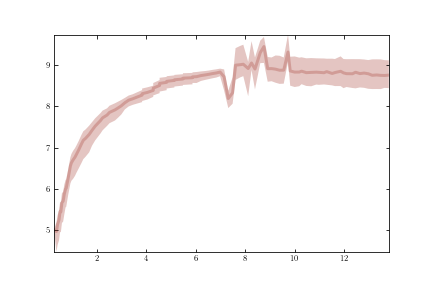

In [49]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 假设 transformations、redshift_snapshot 函数以及 FT 函数已定义
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function
# grp 和 cl 颜色定义

path1 = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'
path1_b = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5'

def read_hdf5_data(path, data_key):
    """从 HDF5 文件中读取数据，并转换为 NumPy 数组。"""
    data = []
    snaps = []
    with h5py.File(path, 'r') as hdf:
        for galaxy_id in hdf.keys():
            galaxy_data = hdf[galaxy_id][data_key][()]
            galaxy_snaps = hdf[galaxy_id]['Snap'][()]
            data.extend(galaxy_data)
            snaps.extend(galaxy_snaps)
    return np.array(data), np.array(snaps)

star_mass, snaps_star = read_hdf5_data(path1, 'Star_mass')
stellar_mass, snaps_stellar = read_hdf5_data(path1_b, 'Stellar_mass')

# 合并所有快照的数据
all_snaps = np.unique(np.concatenate((snaps_star, snaps_stellar)))
max_length = max(len(star_mass), len(stellar_mass))
all_data_matrix = np.full((len(all_snaps), max_length), np.nan)  # 初始化为 NaN

for i, snap in enumerate(all_snaps):
    data_star = star_mass[snaps_star == snap]
    data_stellar = stellar_mass[snaps_stellar == snap]
    all_data_matrix[i, :len(data_star)] = data_star
    all_data_matrix[i, :len(data_stellar)] = data_stellar

# 计算统计值
medians = np.nanmedian(all_data_matrix, axis=1)
lower_quartiles = np.nanpercentile(all_data_matrix, 16, axis=1)
upper_quartiles = np.nanpercentile(all_data_matrix, 84, axis=1)

# 转换快照到红移值
redshifts = FT(redshift_snapshot(all_snaps))

# 计算异常值
outlier_threshold = 84
differences = np.abs(all_data_matrix - medians[:, None])
median_differences = np.nanmedian(differences, axis=1)
outlier_index = np.where(median_differences > np.nanpercentile(median_differences, 100 - outlier_threshold))[0]

# 绘图
plt.figure()
plt.plot(redshifts, np.log10(medians), color=cl, linewidth=3)
plt.fill_between(redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color=cl, edgecolor='none')

# 转换所有快照到红移值的映射
snap_to_redshift = {snap: FT(redshift_snapshot(snap)) for snap in all_snaps}

# 突出显示异常值
for i in outlier_index:
    # 获取异常值所对应的快照编号
    outlier_snaps = all_snaps[all_data_matrix[i, :] != np.nan]
    # 将快照编号转换为红移值
    outlier_redshifts = [snap_to_redshift[snap] for snap in outlier_snaps]
    # 绘制异常值
    plt.plot(outlier_redshifts, np.log10(all_data_matrix[i, :len(outlier_redshifts)]), linestyle='--', color=grp, linewidth=4)

plt.xlabel('Redshift')
plt.ylabel('Log Stellar Mass')
plt.title('Stellar Mass Evolution')
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/tmp/ipykernel_298682/1240670727.py:56: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)


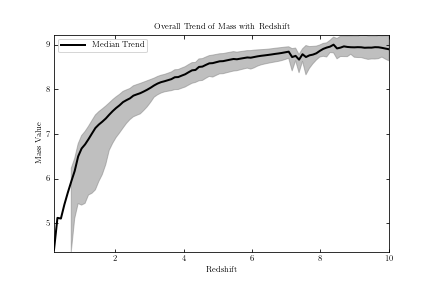

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 定义 transformations、redshift_snapshot 函数以及 FT 函数
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function
# path1 = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5'
# path1_b = '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5'

paths = ['/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5']
data_keys = ['Star_mass', 'Star_mass', 'Stellar_mass', 'Stellar_mass']

# 定义红移点的统一范围
min_redshift = 0.0
max_redshift = 10.0
num_points = 100
uniform_redshifts = np.linspace(min_redshift, max_redshift, num_points)

# 初始化数组来存储插值后的所有数据
all_interpolated_data = []

for path, data_key in zip(paths, data_keys):
    with h5py.File(path, 'r') as f:
        for galaxy_id in f.keys():
            data = f[galaxy_id][data_key][:]
            snaps = f[galaxy_id]['Snap'][()]
            redshifts = FT(redshift_snapshot(snaps))

            # 确保 data 和 redshifts 是数组或序列
            data = np.atleast_1d(data)
            redshifts = np.atleast_1d(redshifts)

            # 创建插值函数
            if len(redshifts) > 1 and len(data) > 1:  # 只有在有多个数据点时才进行插值
                interp_func = interp1d(redshifts, data, kind='linear', bounds_error=False, fill_value=np.nan)
                interpolated_data = interp_func(uniform_redshifts)
                all_interpolated_data.append(interpolated_data)

# 将所有数据转换为 NumPy 数组
all_interpolated_data = np.array(all_interpolated_data)

# 计算统计值
medians = np.nanmedian(all_interpolated_data, axis=0)
lower_quartiles = np.nanpercentile(all_interpolated_data, 25, axis=0)
upper_quartiles = np.nanpercentile(all_interpolated_data, 75, axis=0)

plt.figure()

# 绘制趋势线和误差范围
plt.plot(uniform_redshifts, np.log10(medians), color='black', linewidth=2, label='Median Trend')
plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)

plt.xlabel('Redshift')
plt.ylabel('Mass Value')
plt.title('Overall Trend of Mass with Redshift')
plt.legend()
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

In [3]:
# ...之前的代码...

# 计算每个红移点的星系数量
star_count_per_redshift = np.sum(~np.isnan(all_interpolated_data), axis=0)

# 定义星系数量的阈值，例如至少要有10%的星系包含该红移点
threshold = 0.1 * len(all_interpolated_data)

# 初始化数组来存储主趋势和异常值的数据
main_trend_data = np.copy(all_interpolated_data)
outlier_data = np.full_like(all_interpolated_data, np.nan)

# 判断主趋势和异常值
for i in range(len(uniform_redshifts)):
    if star_count_per_redshift[i] < threshold:
        main_trend_data[:, i] = np.nan  # 将主趋势中的异常值设置为 NaN
        outlier_data[:, i] = all_interpolated_data[:, i]  # 保留异常值

# 计算主趋势的统计值
medians = np.nanmedian(main_trend_data, axis=0)
lower_quartiles = np.nanpercentile(main_trend_data, 25, axis=0)
upper_quartiles = np.nanpercentile(main_trend_data, 75, axis=0)

# 绘制主趋势
plt.plot(uniform_redshifts, medians, color='black', linewidth=2, label='Median Trend')
plt.fill_between(uniform_redshifts, lower_quartiles, upper_quartiles, color='gray', alpha=0.5)

# 突出显示异常值
for outlier_row in outlier_data:
    plt.plot(uniform_redshifts, outlier_row, linestyle='--', color='red', alpha=0.5)

plt.xlabel('Redshift')
plt.ylabel('Mass Value')
plt.title('Overall Trend of Mass with Redshift')
plt.legend()
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

NameError: name 'all_interpolated_data' is not defined

/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/bianyuan/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/tmp/ipykernel_319461/997632559.py:74: RuntimeWarning: divide by zero encountered in log10
  plt.plot(uniform_redshifts, np.log10(outlier_row), linestyle='--', color='red', alpha=0.5)


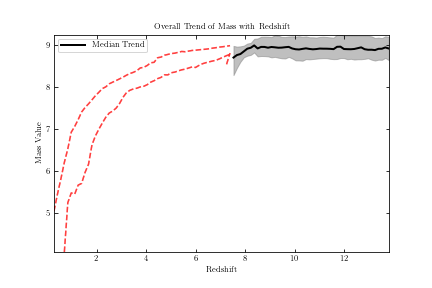

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 定义 transformations、redshift_snapshot 函数以及 FT 函数
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function

paths = ['/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5']
data_keys = ['Star_mass', 'Star_mass', 'Stellar_mass', 'Stellar_mass']

# 定义红移点的统一范围
min_redshift = 0.0
max_redshift = FT(redshift_snapshot(99))
num_points = 100
uniform_redshifts = np.linspace(min_redshift, max_redshift, num_points)

# 初始化数组来存储插值后的所有数据
all_interpolated_data = []

for path, data_key in zip(paths, data_keys):
    with h5py.File(path, 'r') as f:
        for galaxy_id in f.keys():
            data = f[galaxy_id][data_key][:]
            snaps = f[galaxy_id]['Snap'][()]
            redshifts = FT(redshift_snapshot(snaps))

            # 确保 data 和 redshifts 是数组或序列
            data = np.atleast_1d(data)
            redshifts = np.atleast_1d(redshifts)

            # 创建插值函数
            if len(redshifts) > 1 and len(data) > 1:  # 只有在有多个数据点时才进行插值
                interp_func = interp1d(redshifts, data, kind='linear', bounds_error=False, fill_value=np.nan)
                interpolated_data = interp_func(uniform_redshifts)
                all_interpolated_data.append(interpolated_data)

# 将所有数据转换为 NumPy 数组
all_interpolated_data = np.array(all_interpolated_data)

# 计算每个红移点的星系数量
star_count_per_redshift = np.sum(~np.isnan(all_interpolated_data), axis=0)

# 定义星系数量的阈值，例如至少要有10%的星系包含该红移点
threshold = 0.1 * len(all_interpolated_data)

# 初始化数组来存储主趋势和异常值的数据
main_trend_data = np.copy(all_interpolated_data)
outlier_data = np.full_like(all_interpolated_data, np.nan)

# 判断主趋势和异常值
for i in range(len(uniform_redshifts)):
    if star_count_per_redshift[i] < threshold:
        main_trend_data[:, i] = np.nan  # 将主趋势中的异常值设置为 NaN
        outlier_data[:, i] = all_interpolated_data[:, i]  # 保留异常值

# 计算主趋势的统计值
medians = np.nanmedian(main_trend_data, axis=0)
lower_quartiles = np.nanpercentile(main_trend_data, 25, axis=0)
upper_quartiles = np.nanpercentile(main_trend_data, 75, axis=0)

plt.figure()

# 绘制主趋势
plt.plot(uniform_redshifts, np.log10(medians), color='black', linewidth=2, label='Median Trend')
plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)

# 突出显示异常值
for outlier_row in outlier_data:
    plt.plot(uniform_redshifts, np.log10(outlier_row), linestyle='--', color='red', alpha=0.5)

plt.xlabel('Redshift')
plt.ylabel('Mass Value')
plt.title('Overall Trend of Mass with Redshift')
plt.legend()
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/tmp/ipykernel_298682/3649002249.py:61: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)


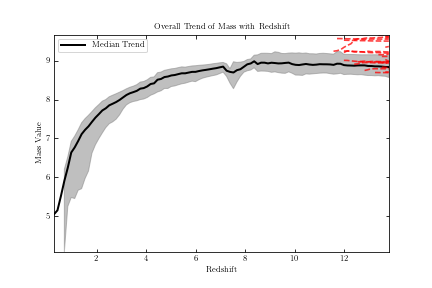

In [19]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 定义 transformations、redshift_snapshot 函数以及 FT 函数
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function

paths = ['/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5']
data_keys = ['Star_mass', 'Star_mass', 'Stellar_mass', 'Stellar_mass']

# 定义红移点的统一范围
min_redshift = 0.0
max_redshift = FT(redshift_snapshot(99))
num_points = 100
uniform_redshifts = np.linspace(min_redshift, max_redshift, num_points)

# 初始化数组来存储插值后的所有数据
all_interpolated_data = []

for path, data_key in zip(paths, data_keys):
    with h5py.File(path, 'r') as f:
        for galaxy_id in f.keys():
            data = f[galaxy_id][data_key][:]
            snaps = f[galaxy_id]['Snap'][()]
            redshifts = FT(redshift_snapshot(snaps))

            # 确保 data 和 redshifts 是数组或序列
            data = np.atleast_1d(data)
            redshifts = np.atleast_1d(redshifts)

            # 创建插值函数
            if len(redshifts) > 1 and len(data) > 1:  # 只有在有多个数据点时才进行插值
                interp_func = interp1d(redshifts, data, kind='linear', bounds_error=False, fill_value=np.nan)
                interpolated_data = interp_func(uniform_redshifts)
                all_interpolated_data.append(interpolated_data)

# 将所有数据转换为 NumPy 数组
all_interpolated_data = np.array(all_interpolated_data)

# 定义星系数量的阈值，例如至少要有10%的星系包含该红移点
threshold = 0.1 * len(all_interpolated_data)

# 检测并标记异常星系
is_outlier_galaxy = np.sum(~np.isnan(all_interpolated_data), axis=1) < threshold

# 计算主趋势的统计值（仅包括非异常星系）
main_trend_data = all_interpolated_data[~is_outlier_galaxy]
medians = np.nanmedian(main_trend_data, axis=0)
lower_quartiles = np.nanpercentile(main_trend_data, 25, axis=0)
upper_quartiles = np.nanpercentile(main_trend_data, 75, axis=0)

plt.figure()

# 绘制主趋势
plt.plot(uniform_redshifts, np.log10(medians), color='black', linewidth=2, label='Median Trend')
plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)

# 突出显示异常星系
for i, outlier in enumerate(is_outlier_galaxy):
    if outlier:
        plt.plot(uniform_redshifts, np.log10(all_interpolated_data[i]), linestyle='--', color='red', alpha=0.5)

plt.xlabel('Redshift')
plt.ylabel('Mass Value')
plt.title('Overall Trend of Mass with Redshift')
plt.legend()
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')

/tmp/ipykernel_298682/419602690.py:68: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)


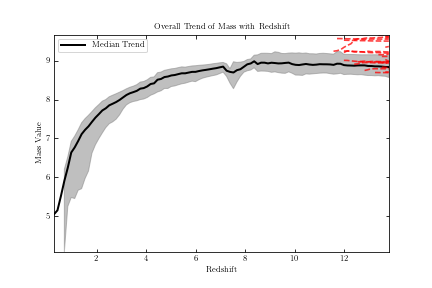

In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 定义 transformations、redshift_snapshot 函数以及 FT 函数
# 示例：FT = transformations['FT']
# redshift_snapshot = your_redshift_snapshot_function

paths = ['/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl_CSSs_evolution.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5', 
         '/home/bianyuan/workspace/data/New_class/MRI/MRI_cl.hdf5']
data_keys = ['Star_mass', 'Star_mass', 'Stellar_mass', 'Stellar_mass']

# 定义红移点的统一范围
min_redshift = 0.0
max_redshift = FT(redshift_snapshot(99))
num_points = 100
uniform_redshifts = np.linspace(min_redshift, max_redshift, num_points)

# 初始化数组来存储插值后的所有数据
all_interpolated_data = []

for path, data_key in zip(paths, data_keys):
    with h5py.File(path, 'r') as f:
        for galaxy_id in f.keys():
            data = f[galaxy_id][data_key][:]
            snaps = f[galaxy_id]['Snap'][()]
            redshifts = FT(redshift_snapshot(snaps))

            # 确保 data 和 redshifts 是数组或序列
            data = np.atleast_1d(data)
            redshifts = np.atleast_1d(redshifts)

            # 创建插值函数
            if len(redshifts) > 1 and len(data) > 1:  # 只有在有多个数据点时才进行插值
                interp_func = interp1d(redshifts, data, kind='linear', bounds_error=False, fill_value=np.nan)
                interpolated_data = interp_func(uniform_redshifts)
                all_interpolated_data.append(interpolated_data)

# 将所有数据转换为 NumPy 数组
all_interpolated_data = np.array(all_interpolated_data)

# 计算每个红移点的星系数量
star_count_per_redshift = np.sum(~np.isnan(all_interpolated_data), axis=0)

# 定义星系数量的阈值，例如至少要有10%的星系包含该红移点
threshold = 0.1 * len(all_interpolated_data)

# 检测并标记异常星系
is_outlier_galaxy = np.zeros(len(all_interpolated_data), dtype=bool)
for i, row in enumerate(all_interpolated_data):
    count = np.sum(~np.isnan(row))  # 计算该星系非NaN数据的数量
    if count < threshold:
        is_outlier_galaxy[i] = True

# 计算主趋势的统计值（仅包括非异常星系）
main_trend_data = all_interpolated_data[~is_outlier_galaxy]
medians = np.nanmedian(main_trend_data, axis=0)
lower_quartiles = np.nanpercentile(main_trend_data, 25, axis=0)
upper_quartiles = np.nanpercentile(main_trend_data, 75, axis=0)

plt.figure()

# 绘制主趋势
plt.plot(uniform_redshifts, np.log10(medians), color='black', linewidth=2, label='Median Trend')
plt.fill_between(uniform_redshifts, np.log10(lower_quartiles), np.log10(upper_quartiles), color='gray', alpha=0.5)

# 突出显示异常值
for i, outlier in enumerate(is_outlier_galaxy):
    if outlier:
        plt.plot(uniform_redshifts, np.log10(all_interpolated_data[i]), linestyle='--', color='red', alpha=0.5)

plt.xlabel('Redshift')
plt.ylabel('Mass Value')
plt.title('Overall Trend of Mass with Redshift')
plt.legend()
plt.savefig('/home/bianyuan/workspace/pic/combine_test.pdf')